In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 385 (delta 86), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (385/385), 105.74 KiB | 7.55 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.8 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.

In [2]:
import cuml
cuml.__version__

'23.04.01'

In [ ]:

import sys
import os
from google.colab import drive
drive.mount('/content/drive/')
!pip install medmnist
!pip install torch
!pip install gputil
!pip install psutil
!pip install humanize
ROOT = "/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/"
sys.path.append(ROOT)
!nvidia-smi
slurm_id = 0


In [37]:
import medmnist

import argparse
import builtins
import math
import os
import random
import shutil
import time
import tqdm
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
# import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
# import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import ImageFilter

import builder


In [5]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("using device: ", dev)


using device:  cuda:0


In [6]:
test_dataset = medmnist.PathMNIST("test", download=False, root=ROOT + "/datasets/", 
                                  transform=transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                  ]))


# Supervised

In [64]:
# t sne visualization
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

model = torch.load(ROOT + "./supervised/72333_epoch15_batch128_lr0.01_momentum0.9_wd0.0001_on-pretrainTrue_aug-colourTrue_optimizerAdam.pickle")
model.to(device)
model.projection_head = Identity()

EMB_SIZE = 1000

# MOCO

In [51]:
class MocoAdaptor(torch.nn.Module):
    def __init__(self, backbone):
        super(MocoAdaptor, self).__init__()

        self.backbone = backbone

    def forward(self, x):
        q = self.backbone.encoder_q(x)
        embedding = nn.functional.normalize(q, dim=1)

        return embedding
        
backbone = torch.load(ROOT + "./moco/71101_epochs20_batch128_lr0.03_momentum0.9_moco-momentum0.999_loss-typeself_V2True.pickle").to(device)
model = MocoAdaptor(backbone)

EMB_SIZE = 128

# Common Eval Code

In [40]:
# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=512, shuffle=True, drop_last=True)
# for x, y in test_loader:
#   break

# plot_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=512)
plot_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)


In [65]:
model.eval()
embedding = torch.zeros((0, EMB_SIZE), device=device)
label = torch.zeros((0, 1), device=device)
with torch.no_grad():
  with tqdm.tqdm(plot_test_loader, unit="batch") as tepoch: 
    for i, (x, y) in enumerate(tepoch):
      embedding = torch.vstack([embedding, model(x.to(device))])
      label = torch.vstack([label, y.to(device)])

100%|██████████| 15/15 [00:33<00:00,  2.21s/batch]


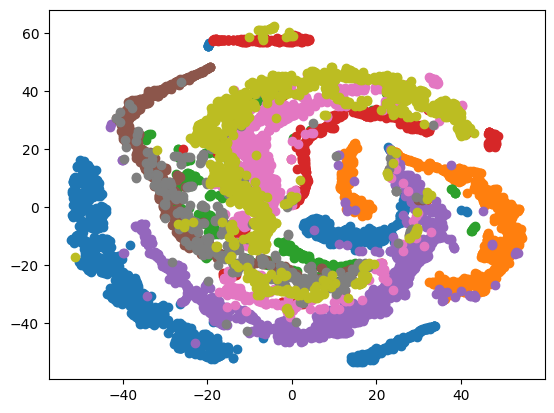

In [74]:
import matplotlib.pyplot as plt
from cuml.manifold import TSNE as cumlTSNE
tsne = cumlTSNE(n_components=2, perplexity=30, learning_rate_method='auto', init='random', n_neighbors=150, n_iter=2000)
z_embedded = tsne.fit_transform(embedding)

# z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embedding)

cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(0, y.max()+1):
  fst = z_embedded[(label.cpu() == i).squeeze(), 0]
  snd = z_embedded[(label.cpu() == i).squeeze(), 1]
  plt.scatter(fst.get(), snd.get(), c=cs[i])
